# Predicting Box Office Revenue

## Preprocessing and Training Notebook

The purpose of this notebook is twofold:

First I want to reduce the dimensionality of my data set in order to make the machine learning models I have to work with more tenable. Currently I have over 10,000 features and only 2,333 observations in the data set, causing serious computational slowdown for my models.  Further, at the time when this notebook was initially written the machine I'm working on didn't have the computational power to even create dummy variables from my 'cast' and 'crew' categories.  


I plan to 'bin' categorical dummy variables into new features to reduce dimensionality.  This is relatively easy for features that are highly skewed (spoken language) or where each variable has a low frequency in the data set compared to 'None' (collection).  However I'll need to test performance on a basic linear/polynomial regressor for other categories where the data is exponentially skewed and there isn't a clear way to bin the data.  This will allow me to compare R^2 and Mean Absolute Percent Error metrics and determine which method for dimensionality reduction allows for the more accurate model. 

Finally, I'll use Lasso and Ridge regressors to test my initial linear regressor for overfit; additionally I'll be able to use the Lasso regressor coefficients to determine what features can be dropped to further reduce dimensionality and complexity. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error, r2_score, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyRegressor
import time

In [2]:
# Read in CSV from EDA notebook

boxoffice = pd.read_csv(r'C:\Users\deann\Documents\Data\Box Office Prediction Data\boxoffice_EDA.csv', index_col=0, 
                        header=[0,1])

boxoffice.shape

(2333, 10456)

In [3]:
boxoffice.head(3)

Genre                                                                    \
  Action Adventure Animation Comedy Crime Documentary Drama Family Fantasy   
0      0         0         0      1     0           0     1      1       0   
1      0         0         0      0     0           0     1      0       0   
2      0         1         1      0     0           0     0      1       0   

           ... Release_month                             
  Foreign  ...             3  4  5  6  7  8  9 10 11 12  
0       0  ...             0  0  0  0  0  1  0  0  0  0  
1       0  ...             0  0  0  0  0  0  0  1  0  0  
2       0  ...             0  0  0  0  0  1  0  0  0  0  

[3 rows x 10456 columns]

In [4]:
# Displaying names of top level of multi-index for later reference
boxoffice.columns.get_level_values(0).unique()

Index(['Genre', 'Collection', 'Company', 'Country', 'Spoken_lang', 'Keywords',
       'Descriptive', 'Numerical', 'Release_year', 'Release_month'],
      dtype='object')

## Binning Categorical Data

To begin I want to significantly cut down on the number of features that I have in the data set.  By far the largest category that I have is Keywords, however the distribution of that category and several others presents several options for binning my data.  I can bin them into quartiles by either frequency or median/mean revenue in the data set. 

However I do have several feature categories that I won't be touching: Genre, Release_year, Country, and Release_month.  These categories all have fewer than 70 individual features.  Additionally I have a compelling reason to believe that each of these will have a large impact on revenue.  Genre, Release_year, and Release_month all were significantly more evenly distributed across films than other categories.  For these three categories median revenue was also skewed towards certain sub-categories which indicates that they have an impact revenue.  

While the Country category is **heavily** skewed towards films made in the United States, revenue is heavily skewed towards more 'exotic' countries.  This is likely a result of blockbuster films like 'Pirates of the Carribean' or 'The Avengers' being filmed on site in other locations.  I suspect that this category will be highly correlated with budget and may be dropped after I check Lasso regresor coefficients.  Regardless, this category only has 67 sub-categories and consolidating those into fewer bins will lose what appears to be useful information with minimal impact on reducing the 10,456 dimensions that the data set currently has.

This means that I need to bin the Spoken_lang, Company, Keywords, and Collection columns.  Later I'll come back through and treat the Cast and Crew categories the same as the Keyword category once I have access to a machine with enough RAM to handle those categories. 

The best place for me to start with binning is going to be the Spoken_lang category since it's highly skewed towards the 'English' sub-category.  

#### Binning Spoken_lang

Based on the work from my EDA notebook the 'English' sub-category accounts for 2,180 films in this data set.  It's clear that the simplest way to bin this category is to reduce it to a single column that indicates if a film's primary language is English or not.

In [5]:
# Create a list of column lables to be dropped
dropped = list(boxoffice['Spoken_lang'].columns)
dropped.remove('English')

In [6]:
# for loop to iterate over the dropped list and remove all languages from Spoken_lang other than english

for col in dropped:
    boxoffice.drop(col, level=1, axis=1, inplace=True)

In [7]:
# verify that English is the only remaining column
boxoffice.Spoken_lang.head(3)

,English
0,1
1,1
2,1


#### Binning Film Collection dummy variables

Ultimately this was going to be relatively complex with the multi-indexed dataframe so I went back to my EDA notebook and created a boolean column that indicates if a film belongs to a collection or not.  The final step is to transform this into the value for 1 or 0. 

In [8]:
# Casting the column in question to a numeric data type
boxoffice['Descriptive', 'Collection'] = boxoffice['Descriptive', 'Collection'].astype('int')
boxoffice['Descriptive', 'Collection'].head(3)

0    1
1    0
2    0
Name: (Descriptive, Collection), dtype: int32

In [9]:
boxoffice['Descriptive'].head(3)

,original_title,overview,tagline,title,Collection
0,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,1
1,Whiplash,"Under the direction of a ruthless instructor, ...",The road to greatness can take you to the edge.,Whiplash,0
2,Pinocchio and the Emperor of the Night,"Pinocchio and his friends, a glow worm and a m...",NaN,Pinocchio and the Emperor of the Night,0


While I'm working on this column in Descriptive I'm also going to drop the overview, tagline, and original_title columns, and set the index to the title column

In [10]:
boxoffice.drop('overview', level=1, axis=1, inplace=True)
boxoffice.drop('tagline', level=1, axis=1, inplace=True)
boxoffice.drop('original_title', level=1, axis=1, inplace=True)
# Storing the titles in a seperate Series for later use as needed
Titles = boxoffice['Descriptive', 'title']
boxoffice.drop('title', level=1, axis=1, inplace=True)

In [11]:
#Verify that the Descriptive category has been reduced to only the one-hot encoded column for collections
boxoffice['Descriptive'].head(3)

,Collection
0,1
1,0
2,0


## Testing the accuracy of linear regression with the data set as is

At this point I have a huge number of columns, and I haven't made significant reductions in the number of features yet. 

However once I've binned the Company and Keyword columns I'll have eliminated thousands of features.  Prior to doing this I want to get a baseline for how accurate a model is with all of these columns left in the data set. 

The reason that this is important to do now, prior to reducing the dimensionality of the Company and Keywords categories is that each movie has multiple companies and keywords associated with it, while there is only a single language and film collection for each movie.  Reducing the Spoken_lang and Collection categories isn't eliminating complex information about each film like binning the Company and Keywords categories will be. 

This will also give me a baseline of accuracy prior to scaling the numeric data that I have to work with as well.

If the model takes excessively long to train I'll be forced to trim a lot of those columns from my data set, so I'll need to take the time required to run and print that as well as test the accuracy of the model. 

#### Renaming columns in Release_month

While working with dummy variables I think that it's wise to rename the columns for Release_month since it's possible that I'll be dropping the hierarchical index before creating a train/test split and training my model. 

In [12]:
months ={'1':'Jan', '2':'Feb', '3':'Mar', '4':'Apr', '5':'May', '6':'June', 
         '7':'July', '8':'Aug', '9':'Sep', '10':'Oct', '11':'Nov', '12':'Dec'}
boxoffice.rename(columns=months, level=1, inplace=True)
boxoffice['Release_month'].head(3)

,Jan,Feb,Mar,Apr,May,June,July,Aug,Sep,Oct,Nov,Dec
0,0,0,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,1,0,0,0,0


#### Creating the train/test split

In [13]:
y = boxoffice['Numerical', 'revenue']
y.head(3)

0    134734481.0
1     48982041.0
2      3418605.0
Name: (Numerical, revenue), dtype: float64

In [14]:
X = boxoffice.drop('revenue', level=1, axis=1)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

#### Evaluating the mean as a predictor

In [16]:
mean_reg = DummyRegressor(strategy='mean')
mean_reg.fit(X_train, y_train)
mean_reg.constant_

array([[1.49246951e+08]])

In [17]:
# Evaluating the mean with mean absolute percent error, R-squared, and root mean squared error
pred = mean_reg.predict(X_test)
MAPE_mean = round(mean_absolute_percentage_error(y_test, pred), 5)*100
R2_mean = round(r2_score(y_test, pred), 5)
RMSE_mean = round(mean_squared_error(y_test, pred, squared=False), 5)

print('Mean predictor mape score: ', MAPE_mean)
print('Mean predictor r^2 score: ', R2_mean)
print('Mean predictor rmse score: ', RMSE_mean)

Mean predictor mape score:  2288.3849999999998
Mean predictor r^2 score:  -0.00113
Mean predictor rmse score:  167013048.70898


#### Testing the model's accuracy

In [18]:
linear_1 = LinearRegression()

In [19]:
# Training the first regressor and noting the time it takes to train
train_start = time.time()
linear_1.fit(X_train, y_train)
train1_finish = time.time()
print('Time to train: ', str(round(train1_finish-train_start, 3)))

Time to train:  4.277


In [20]:
# predicting new values with the first regressor
preds = linear_1.predict(X_test)

# calculating R^2 and Mean Absolute Percentage Error
MAPE_1 = round(mean_absolute_percentage_error(y_test, preds), 5)*100
R2_1 = round(r2_score(y_test, preds), 5)
RMSE_1 = round(mean_squared_error(y_test, preds, squared=False), 5)

print('Baseline test mape scpre: ', MAPE_1)
print('Baseline test R^2 score: ', R2_1)
print('Baseline test rmse score: ', RMSE_1)

Baseline test mape scpre:  675.942
Baseline test R^2 score:  0.39158
Baseline test rmse score:  130199031.78982


Here it's clear that my initial model is not all that accurate from the R^2 score.  Additionally, my model is off on revenue prediction by 680% on average, which indicates to me that the baseline linear regression model here is an 'accurate guess' at revenue.  

It's not clear from this whether the low scores are a result of overfitting, or because I need to choose a different model for this data set.  Prior to moving forward I need to determine how well the model can predict using only the training data. 

In [21]:
# To get a sense for overfit I also want to see how well the model performs on the training data

train_preds = linear_1.predict(X_train)

MAPE = round(mean_absolute_percentage_error(y_train, train_preds), 5)*100
R2 = round(r2_score(y_train, train_preds), 5)
RMSE = round(mean_squared_error(y_train, train_preds, squared=False), 5)

print('Baseline training mape score: ', MAPE)
print('Baseline training R^2 score: ', R2)
print('Baseline training rmse score: ', RMSE)

Baseline training mape score:  0.001
Baseline training R^2 score:  1.0
Baseline training rmse score:  21.62357


It appears that the issue is that the model is too complex and overfitted to the training data.  I have several options to remedy this but the first step I can take is to reduce the number of features that I have significantly.  

At this point I have several options.  Currently I can bin the production companies and keywords categories into fewer features, and later I'll have access to the cast & crew information as well.  From a business perspective, when a studio is presented a film as an option to invest in they control who is cast in the film, who works on it's crew, and which other studios they collaborate with.  What they don't have control over when presented with a script is what the story **is** - it's already been written.  If the core story of a film is not worth much, then it doesn't make sense to sink additional resources into a quality cast/crew, high-value filming on location in other countries, or collaboration with other studios.   

There are several features that can be used to characterize a story which are immutable about that film.  One is whether it's part of a larger story - a collection - or not. Another feature that a studio has no control over is what genre a film is, if the screenwriter has written a thriller film it's rather difficult to change that into a romantic-comedy.  Finally, there are keywords that can describe a film's nature as well.  Films about detectives and murder can't easily be changed into family-friendly animation movies.  

I've already reduced the dimensionality of the collections category to 1, and the genres category is small enough that I don't see reducing it's dimensionality as effective.  I either need to strip the keywords category down to a few features or eliminate it entirely.  

My instinct is to drop the category in it's entirety, and see how that affects the performance metrics.  The most frequently appearing keywords only appear in 188 films, and the top three most frequen keywords all indicate that a film is part of a larger film collection.  The other frequently occuring keywords indicate if there is a female director for a film, and if the film involves a murder.  All of these features of a film are represented in some way by other categories that the data set contains.  

#### Testing a linear model on only numeric data

Before I spend time dropping categorical data to test how that affects the performance of linear models and overfit I want to see if working with only the numerical data in the dataset is more accurate

In [22]:
Num = boxoffice['Numerical']
y=Num['revenue']
X=Num.drop('revenue', axis=1)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

lin_num = LinearRegression()
start_time = time.time()
lin_num.fit(X_train, y_train)
finish_num_time = time.time()
print('Time to train: ', str(round(finish_num_time-start_time, 3)))

Time to train:  0.011


In [24]:
pred = lin_num.predict(X_test)
MAPE_num = round(mean_absolute_percentage_error(y_test, pred), 3)*100
R2_num = round(r2_score(y_test, pred), 5)
RMSE_num = round(mean_squared_error(y_test, pred, squared=False), 5)

print('Numerical test mape score: ', MAPE_num)
print('Numerical test r^2 score: ', R2_num)
print('Numerical test rmse score: ', RMSE_num)

Numerical test mape score:  468.9
Numerical test r^2 score:  0.49182
Numerical test rmse score:  118991518.84164


Here there is a marginal improvement in the MAPE score, and my R-squared score has improved significanly from the linear regression model trained on the entire data set.  

In [25]:
train_pred = lin_num.predict(X_train)
MAPE = round(mean_absolute_percentage_error(y_train, train_pred), 3)*100
R2 = round(r2_score(y_train, train_pred), 5)
RMSE = round(mean_squared_error(y_train, train_pred, squared=False), 5)

print('Numerical train mape score: ', MAPE)
print('Numerical train r^2 score: ', R2)
print('Numerical train rmse score: ', RMSE)

Numerical train mape score:  1198.8
Numerical train r^2 score:  0.51871
Numerical train rmse score:  124747627.03442


It would appear here that while the model's performance against the test data set has improved significantly, the performance on the training data has decreased significantly with the removal of categorical data.  This could be a good sign since working with the entire data set creates a problem with over-fitting. Examining a plot of predicted vs actual values and plotting the residuals could be helpful.  

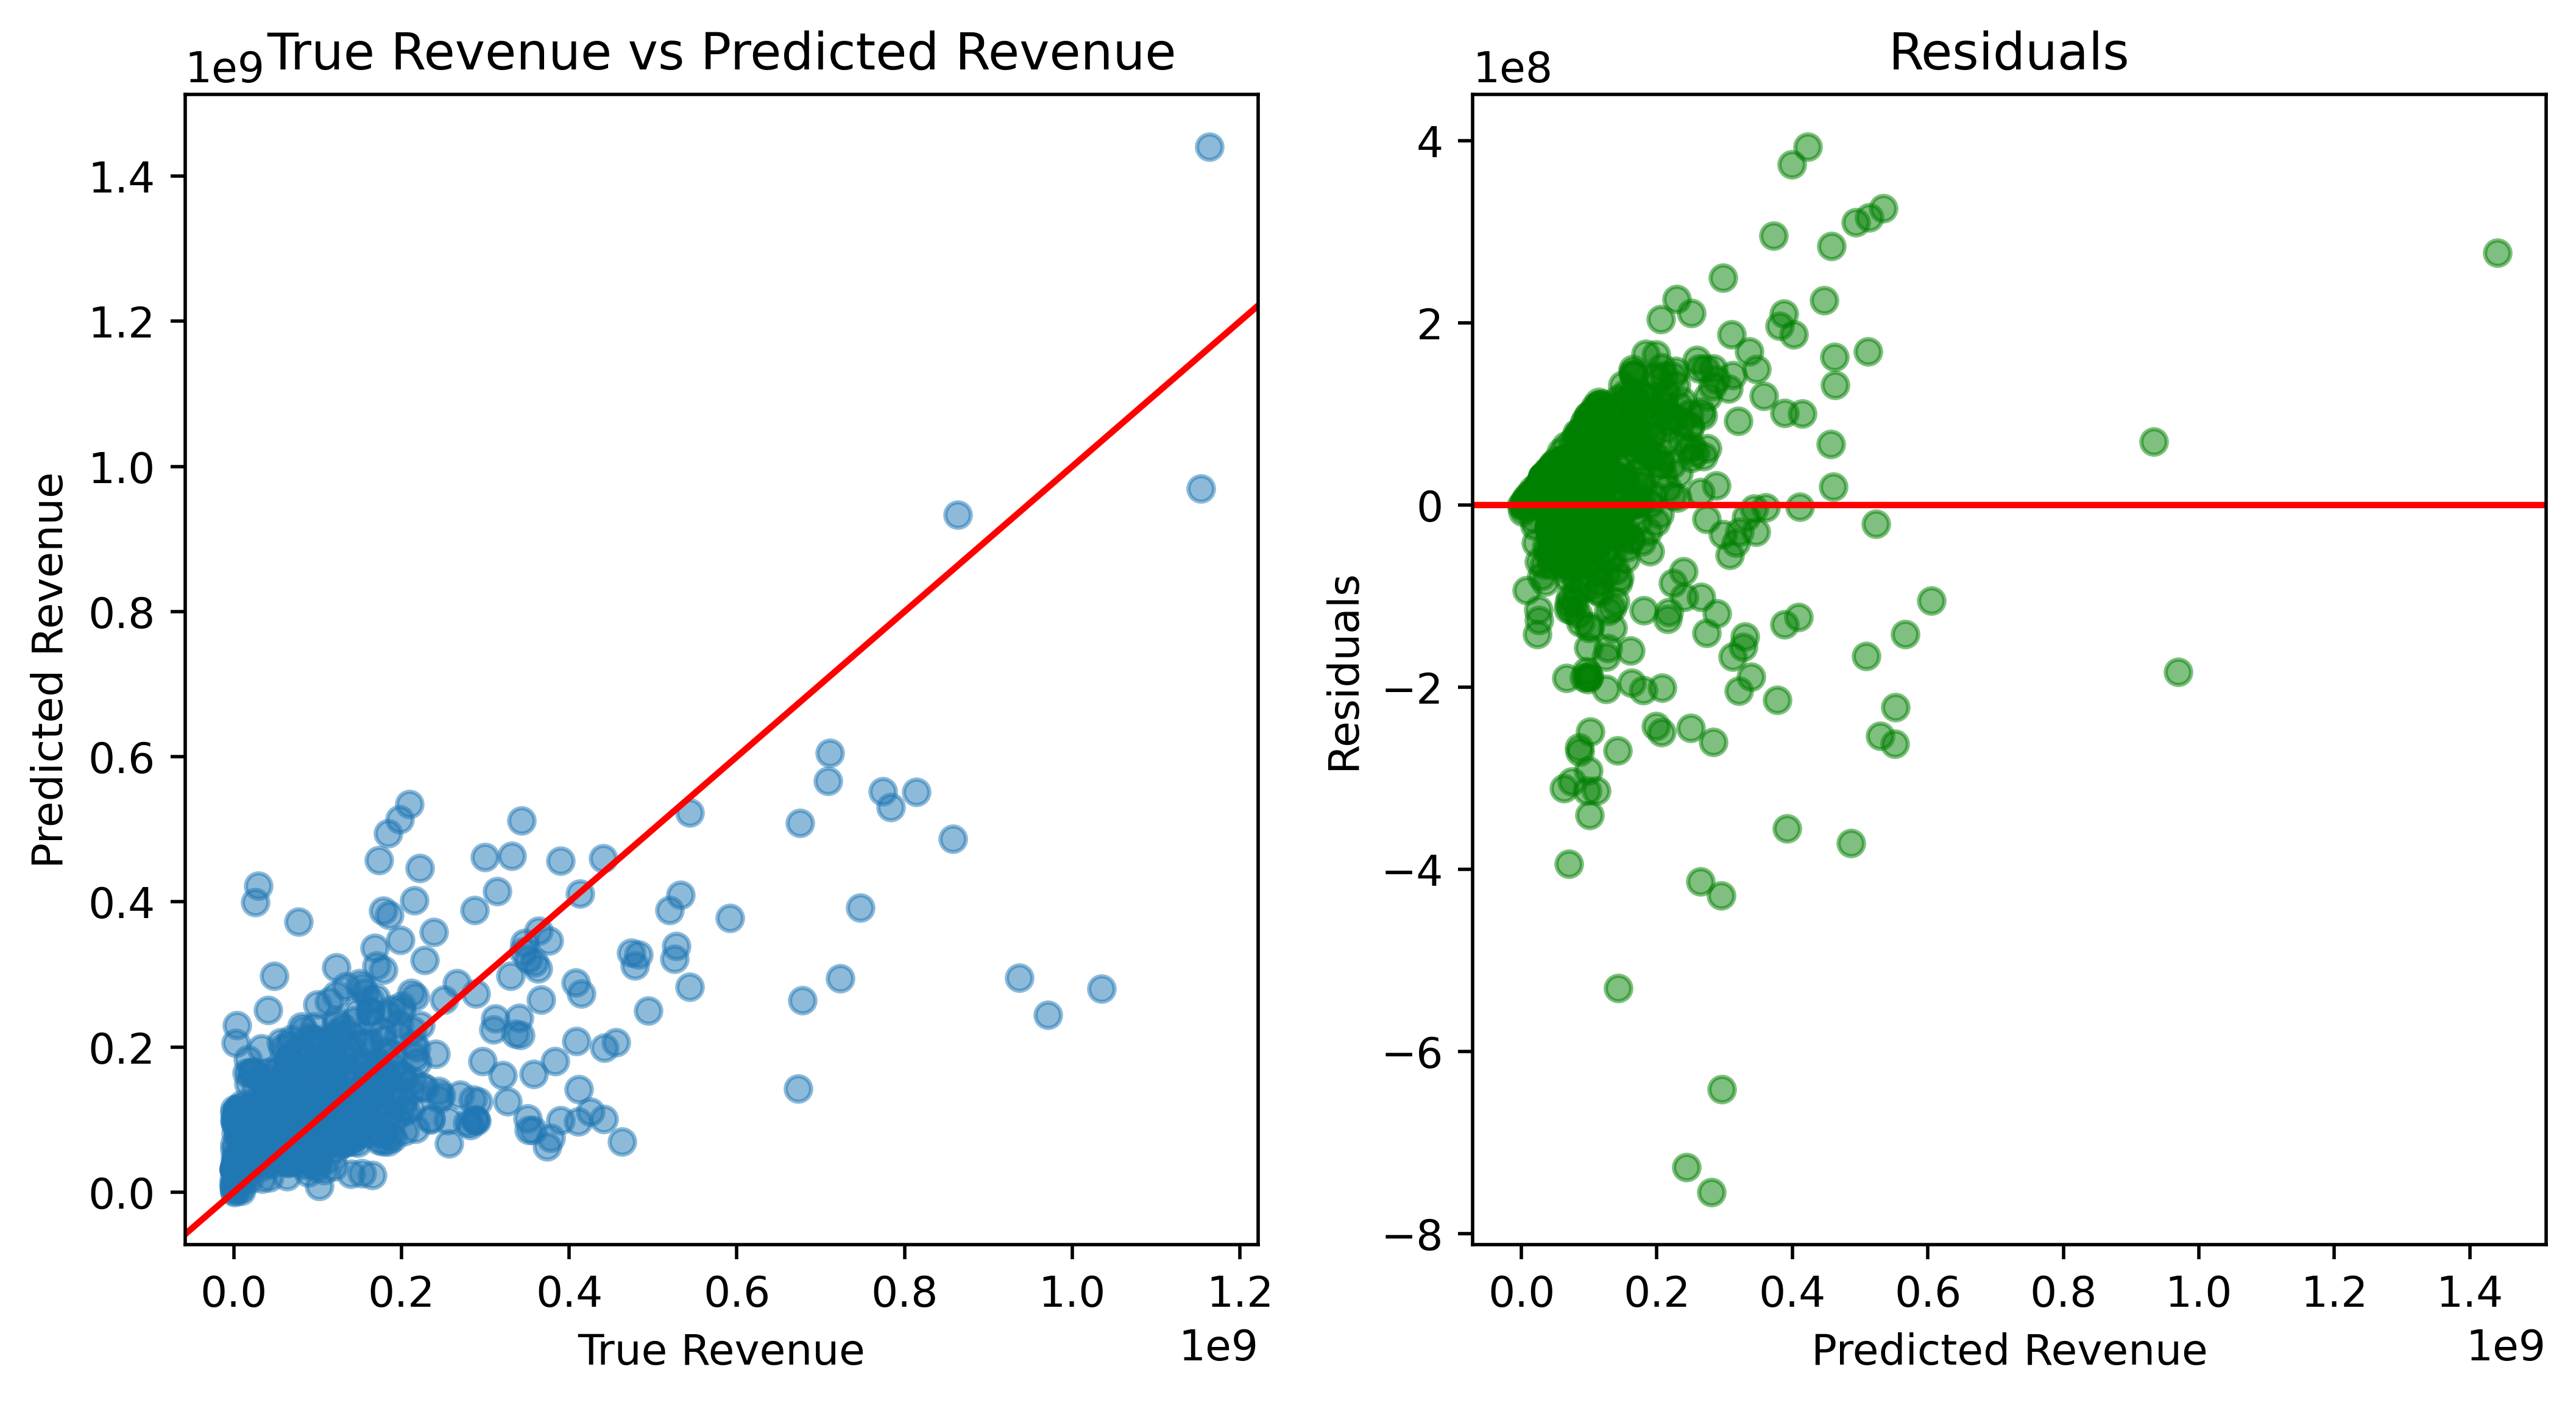

In [26]:
residuals = pred-y_test
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 5), dpi=500)
ax1.scatter(y_test, pred, alpha=0.5)
ax1.set_xlabel('True Revenue')
ax1.set_ylabel('Predicted Revenue')
ax1.set_title('True Revenue vs Predicted Revenue')
ax1.axline((0,0), (1,1), color='r')
ax2.scatter(pred, residuals, color='g', alpha=0.5)
ax2.set_title('Residuals')
ax2.set_xlabel('Predicted Revenue')
ax2.set_ylabel('Residuals')
ax2.axhline(y=0, color='r')
#plt.savefig('Numerical Residuals.png')
plt.show();

Based on these plots, it seems that the linear regression model I have now has a strong tendency to over-predict revenue based on the numerical data I'm presented with.  Moving forward it's important to examine how subsetting the data differently will 

#### Checking to see how frequent keywords appear in the data set

I want to see if there's a convenient place where I could bin this category based on how often keywords appear

In [27]:
# Prior to just dropping all 7,000+ features I want to double check the distribution of the Keywords

#create a new data frame of the keywords category
kwords = boxoffice['Keywords']
count = kwords.apply(pd.value_counts)
x = list(kwords.columns)
y = count.iloc[1]
kwords.shape

(2333, 7134)

In [28]:
# Showing all keywords that appear more than 5 times in the data set
y = y.sort_values(ascending=False)
z = y[y >= 5]
z.shape

(1000,)

Roughly 1 in every 7 of all keywords appear in at least **five** films - the majority of these features are not useful. 

In [29]:
# Checking how many keywords appear in at least 50 films
k = z[z >= 50]
k

duringcreditsstinger    188
based on novel          146
aftercreditsstinger     110
woman director           98
murder                   96
sequel                   90
3d                       85
dystopia                 83
violence                 82
revenge                  67
friendship               61
biography                59
No Keywords              59
superhero                54
love                     53
new york                 53
london england           52
magic                    51
family                   51
based on comic           51
musical                  50
police                   50
alien                    50
Name: 1, dtype: int64

Only 23 of the 7,134 keywords actually appear in 50 or more films.  Five of those keywords indicate that a film is part of a collection, another ten can easily be mapped to genres, and two indicate the filming location.  I'm going to drop the keywords data.  It's not worth binning the keywords with the distribution among films being so extreme, if this dramatically affects the model's accuracy I can always add these 23 columns back into the data set from the kwords data frame

## Testing performance of linear models after reducing dimensionality of the data

The first step here as outlined above, is to test performance on a data set that has had the keywords category eliminated.  I'll also compare these results to those that come after removing the company data.

In [46]:
# Creating a new dataframe without the Keywords categories
trimmed = boxoffice.drop('Keywords', level=0, axis=1)
trimmed.shape

(2333, 3262)

In [47]:
y = trimmed['Numerical', 'revenue']
X = trimmed.drop('revenue', level=1, axis=1)

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [49]:
linear_3 = LinearRegression()
train_start = time.time()
linear_3.fit(X_train, y_train)
train3_finish = time.time()
print('Time to train: ', str(round(train3_finish-train_start, 3)))

Time to train:  2.693


In [50]:
preds = linear_3.predict(X_test)

MAPE_3 = round(mean_absolute_percentage_error(y_test, preds), 5)*100
R2_3 = round(r2_score(y_test, preds), 5)
RMSE_3 = round(mean_squared_error(y_test, preds, squared=False), 5)

print('Trimmed & scaled test mape scpre: ', MAPE_3)
print('Trimmed & scaled test R^2 score: ', R2_3)
print('Trimmed & scaled test rmse score: ', RMSE_3)

Trimmed & scaled test mape scpre:  182808.63
Trimmed & scaled test R^2 score:  -1440938.82142
Trimmed & scaled test rmse score:  200368252226.4883


In [51]:
train_preds = linear_3.predict(X_train)

MAPE = round(mean_absolute_percentage_error(y_train, train_preds), 5)*100
R2 = round(r2_score(y_train, train_preds), 5)
RMSE = round(mean_squared_error(y_train, train_preds), 5)

print('Trimmed & scaled train mape score: ', MAPE)
print("Trimmed & scaled train R^2 score: ", R2)
print('Trimmed & scaled train rmse score: ', RMSE)

Trimmed & scaled train mape score:  106.406
Trimmed & scaled train R^2 score:  0.96374
Trimmed & scaled train rmse score:  1172565608090288.0


The metrics for this model's predictions when measured against the test data are ridiculously high, while the metrics when measured against the training data are significantly lower.  Here I think it's important to plot the data from the model's predictions again for a visual analysis. 

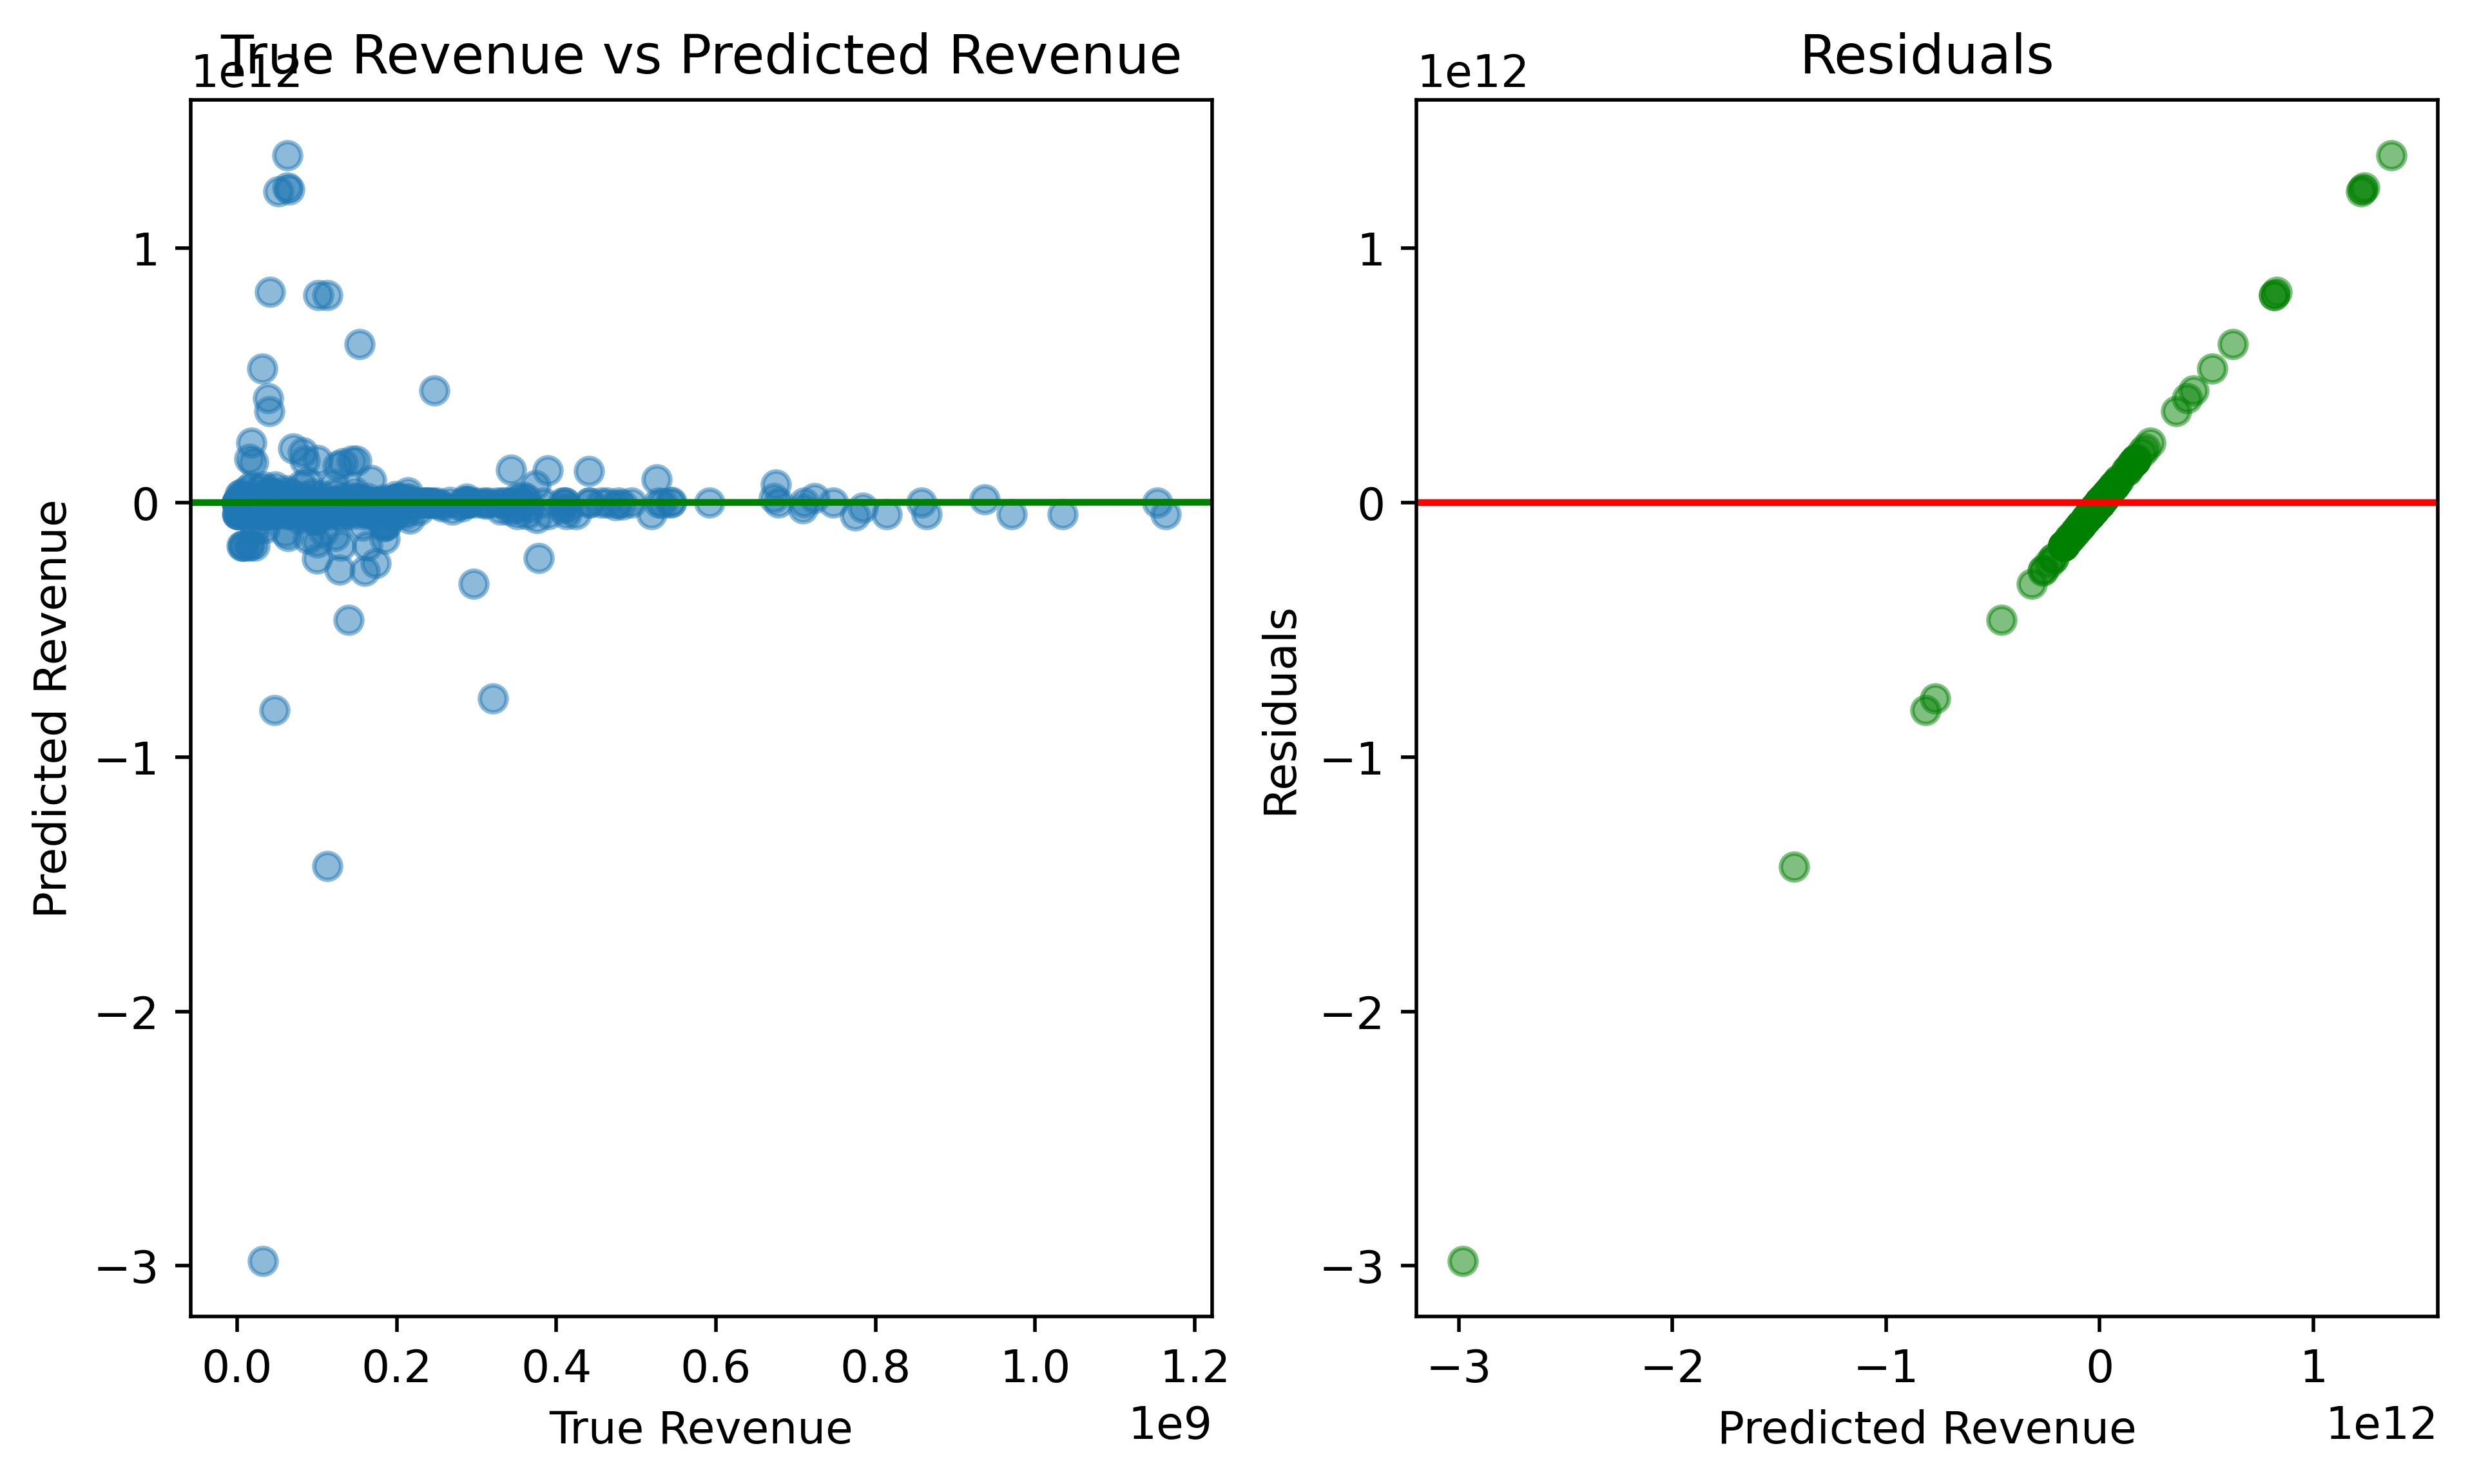

In [52]:
residuals = preds-y_test
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(9, 5), dpi=500)
ax1.scatter(y_test, preds, alpha=0.5)
ax1.set_xlabel('True Revenue')
ax1.set_ylabel('Predicted Revenue')
ax1.set_title('True Revenue vs Predicted Revenue')
ax1.axline((0,0), slope=1, color='g')
ax2.scatter(preds, residuals, color='g', alpha=0.5)
ax2.set_title('Residuals')
ax2.set_xlabel('Predicted Revenue')
ax2.set_ylabel('Residuals')
ax2.axhline(y=0, color='r')
plt.savefig('Numerical Residuals.png')
plt.show();

Based off of this it would appear that the Keywords category has a significant impact on the ability of my model to generalize to unseen data, and on a linear regression model's ability to predict the correct results on even the training data. 

Next it will be useful to see how a linear regression model performs without the company data as well. 

#### Testing linear regression with no company data

This drops 2,748 of the features in the data set

In [40]:
Trimmed2 = boxoffice.drop('Company', level=0, axis=1)
Trimmed2.shape

(2333, 7708)

In [41]:
# Double checking to make sure that the numerical data is still scaled
Trimmed2['Numerical'].head(3)

,budget,popularity,runtime,revenue,Overview_length,Tag_length
0,40000000.0,8.248895,113.0,134734481.0,393.0,60.0
1,3300000.0,64.299990,105.0,48982041.0,130.0,47.0
2,8000000.0,0.743274,83.0,3418605.0,150.0,0.0


In [42]:
y=Trimmed2['Numerical', 'revenue']
X=Trimmed2.drop('revenue', level=1, axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [43]:
linear_4 = LinearRegression()
train_start=time.time()
linear_4.fit(X_train, y_train)
train4_finish=time.time()
print('Time to train: ', str(round(train4_finish-train_start, 3)))

Time to train:  3.741


In [44]:
preds = linear_4.predict(X_test)

MAPE_4 = round(mean_absolute_percentage_error(y_test, preds), 5)*100
R2_4 = round(r2_score(y_test, preds), 5)
RMSE_4 = round(mean_squared_error(y_test, preds, squared=False), 5)

print('No company data mape test score: ', MAPE_4)
print('No company data R^2 test score: ', R2_4)
print('No company data rmse test score: ', RMSE_4)

No company data mape test score:  1370.82
No company data R^2 test score:  0.05365
No company data rmse test score:  162379993.34885


In [ ]:
train_preds = linear_4.predict(X_train)

MAPE = round(mean_absolute_percentage_error(y_train, train_preds), 5)*100
R2 = round(r2_score(y_train, train_preds), 5)
RMSE = round(mean_squared_error(y_train, train_preds, squared=False), 5)

print('No company data mape train score: ', MAPE)
print('No company data, R^2 train score: ', R2)
print('No company data rmse train score: ', RMSE)

After training and examining the metrics for 4 different linear regression models it seems that this isn't the best model for this problem.  Moving forward I'm going to evaluate Lasso and Ridge regressors to check for overfit. 

It is notable that the linear regression model on the data set without the company data had the smallest mean percent and root mean squared error of all the models, however the R-squared metric was almost zero, which is troubling. 

## Testing Lasso regression model's performance

In [ ]:
# First I want to get a baseline level of performance for a model to compare to. 
lasso_5 = Lasso()

In [ ]:
y = boxoffice['Numerical', 'revenue']
X = boxoffice.drop('revenue', level=1, axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
train_start = time.time()
lasso_5.fit(X_train, y_train)
train5_finish = time.time()
print('Time to train: ', str(round(train5_finish-train_start, 3)))

In [ ]:
preds = lasso_5.predict(X_test)
MAPE_5 = round(mean_absolute_percentage_error(y_test, preds), 3)*100
R2_5 = round(r2_score(y_test, preds), 5)
RMSE_5 = round(mean_squared_error(y_test, preds, squared=False), 5)

print('Baseline lasso test mape score: ', MAPE_5)
print('Baseline lasso test r^2 score: ', R2_5)
print('Baseline lasso test rmse score: ', RMSE_5)

In [ ]:
train_preds = lasso_5.predict(X_train)
MAPE = round(mean_absolute_percentage_error(y_train, train_preds), 3)*100
R2 = round(r2_score(y_train, train_preds), 5)
RMSE = round(mean_squared_error(y_train, train_preds, squared=False), 5)

print('Baseline lasso train mape score: ', MAPE)
print('Baseline lasso train r^2 score: ', R2)
print('Baseline lasso train rmse score: ', RMSE)

It seems that none of these models model the data very well.  I haven't gotten a MAPE score below 100%, and neither have I improved the R-squared score above 0.49.  What is baffling is that the same model that gives me a 104% averag error score also gives me and average RMSE of 0.94 USD, which is definitely not 104% of a revenue value for any of the films in this data set. 